# CS 482: Optimal Path Navigation
#### **Goals**
The visually impaired face many challenges in navigating their daily lives in familiar environments, but more importantly, unfamiliar environments. While there is some hope in assisting them with current technology, we seek to provide a more intuitive and effective solution that considers real-time environmental data to provide safer navigation. The goal for this project is to provide the technical foundation for implementing a physical prototype that can be worn by the user and will signal to them a suggested path using vibration gloves.\n",

#### **Needed Libraries**
- Ipykernel, Numpy, Pandas, Pillow, Matplotlib, Scipy
- Transformers: provides access to pre-trained models on the HuggingFace website.
    - Install with pip: `pip install -q transformers`
    - Official Website for further reference: https://huggingface.co/transformers/v3.5.1/installation.html


#### **Testing Data Procedures**
1. Choose an environment to navigate through, such as a study room with tables.
2. Take pictures at various angles in the room so that it captures all of the visible objects in the room.
    - Tip: start at the entrance of the room and walk around, taking photos of the ground and the open space.
3. Decide which photo will be the starting point for your user.

#### **Sources Consulted**
1. Raja, S., Bhatia, T., Mishra, A., Kashyap, S., & Verma, O. P. (2017). Autonomous Pathfinding in Simulated 3D           Environment. *Proceedings of the 2017 International Conference on Robotics and Artificial Intelligence*, 56–60. https://doi.org/10.1145/3175603.3175621
    - This source aims to navigate through an environment simulated with Blender using **depth information (from a CNN)** and path planning. The neural network was trained using randomly generated images, and the path was planned using a "heuristic aided search algorithm" that uses a left and right camera to determine a short term path at every step. The algorithms were tested using the Manhattan distance and the Euclidean distance as the distance heuristics. If objects appear to be too close from the depth estimation, another path is selected until there is a step with no detected obstacles.

2. Perera, G. S. T., Madhubhashini, K. W. R., Lunugalage, D., Piyathilaka, D. V. S., Lakshani, W. H. U., & Kasthurirathna D. (2021). Computer Vision Based Indoor Navigation for Shopping Complexes. Proceedings of the 2020 4th International Conference on Vision, Image and Signal Processing, 15, 1–6. https://doi.org/10.1145/3448823.3448828,
    - The authors created an indoor navigation system that would allow the user to navigate inside shopping malls with audio instructions guiding them. First, computer vision was used to estimate their current location, where a **CNN was trained** with a dataset of the specific malls' signs with their locations on a map. Then, the phone sensors detect the orientation and speed of the user, and the A* algorithm searches for the shortest path to the destination, with audio instructions and a chatbot to lead the user there.

3. Ivanchenko, V., Coughlan, J., Gerrey, W., & Shen, H. (2008). Computer Vision-Based Clear Path Guidance for Blind Wheelchair Users. *Proceedings of the 10th International ACM SIGACCESS Conference on Computers and Accessibility*, 291–292. https://doi.org/10.1145/1414471.1414543.
    - This article describes a prototype meant to guide blind wheelchair users through their environment. Although this source does not specifically plan the path for the user, computer vision is incorporated through the system using stereo vision to alert the user of any obstacles. The **Point Grey Bumblebee 2 stereo camera** is placed above the seat, and the **elevation of the surrounding area** allows the system to detect the obstacles (anything different from the base elevation).
    
4. Rahman, S., Shah, A. S., & Whitney, G. (2004). Computer Vision based navigation system for the visually impaired. *ACM SIGGRAPH 2004 Posters*, 64. https://doi.org/10.1145/1186415.1186489
    - Despite the article only consisting of an extended abstract, the goal of this experiment was to develop a navigation system for visually impaired people based on computer vision, predominantly in outdoor environments. The two main components are "matching key objects from image sequences and matching a pre-defined scene from the image database with image sequences." These techniques involved using various algorithms, including "gray level template matching, shape model matching, scale invariant shape model matching, and edge based shape model matching," and their future research planned to account for different lightings, heights, and objects more commonly found indoors.

5. Sivan, S., & Darsan, G. (2016). Computer Vision based Assistive Technology For Blind and Visually Impaired People. *Proceedings of the 7th International Conference on Computing Communication and Networking Technologies*, 41, 1–8. https://doi.org/10.1145/2967878.2967923
    - Building on related projects with devices assisting the visually impaired, a multi-purpose prototype was created with object detection, text recognition, door detection, and a security feature. The device includes multiple algorithms, specifically Histogram equalization, the Canny Edge detector, and BRISK (Binary Robust Invariant Scalable Keypoints), where images are taken and processed with a raspberry pi system managing the various functions through an input device.

In [6]:
# from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# checkpoint = "vinvino02/glpn-nyu"
# "LiheYoung/depth-anything-base-hf"
# image_processor = AutoImageProcessor.from_pretrained(checkpoint)
# model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

### **Phase 1: Initial Setup -- GitHub, Python Kernel, Python Libraries**
- Creating a cohesive GitHub repository for multiple people to work on code together
- Loading up the Python Kernel for the environment
- Installing the Python Libraries necessary for the project (like numpy and cv2)
    

### **Phase 2: Project Development**
This next phase consists of the actual code for the project, where the depth map and point cloud creation takes place.

### 2.1: Testing the Depth Map Model

In [7]:
from transformers import pipeline

# Possible Models = "vinvino02/glpn-nyu"     OR      "LiheYoung/depth-anything-base-hf"

depth_estimator = pipeline(task="depth-estimation", model="vinvino02/glpn-nyu")
output = depth_estimator("images/book.webp")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [8]:
"""
NOTE: cannot use depth_estimator on a full video.
FIX: convert video to individual frames, run estimator on each frame, and reconvert to video
"""

# output = depth_estimator("videos/IMG_2119.mov")
# This is a tensor with the values being the depth expressed in meters for each pixel
# output["depth"]

'\nNOTE: cannot use depth_estimator on a full video.\nFIX: convert video to individual frames, run estimator on each frame, and reconvert to video\n'

In [ ]:
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")
# This is a tensor with the values being the depth expressed in meters for each pixel
print(output)
print(output["predicted_depth"].shape)
print(output["predicted_depth"])
output["depth"]

In [9]:
from PIL import Image
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

"""
Displays an image, its depth map, and its predicted_depth side by side.

Parameters
----------
img: a Pillow Image object of the image

depth_estimator: the depth_estimator model being used 
    This should be the output of the pipeline command, not the checkpoint string.

title: the text that will be displayed above the middle image
    Defaults to None if no title is needed.

"""
def display_depths(img, depth_estimator, title=None):
    # Display the original image
    plt.figure(figsize=(7.5, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img)

    # Display the depth map
    depths = depth_estimator(img)
    plt.subplot(1, 3, 2)
    plt.imshow(depths["depth"], cmap='gray', vmin=0, vmax=255)
    
    # Display the title
    if title is not None:
        plt.title(title)

    # Display the predicted depths
    plt.subplot(1, 3, 3)
    plt.imshow(depths["predicted_depth"][0], cmap='gray')


img = Image.open("images/room2.webp")
img_array = np.asarray(img)[:, :, 0]
low_contrast = np.zeros((3, 3))
low_contrast[1, 1] = 0.5
low_cont_img = Image.fromarray(scipy.signal.convolve2d(img_array, low_contrast, mode='same'))

high_contrast = np.zeros((3, 3))
high_contrast[1, 1] = 2
high_cont_img = Image.fromarray(scipy.signal.convolve2d(img_array, high_contrast, mode='same'))

sharpen = np.zeros((3, 3))
sharpen[1, 1] = 2
sharpen = sharpen - (1.0 / 5) * np.ones((3, 3))
sharp_img = Image.fromarray(scipy.signal.convolve2d(img_array, sharpen, mode='same'))



display_depths(img, depth_estimator, title="Original Image")
display_depths(low_cont_img, depth_estimator, title="Low Contrast Image")
display_depths(high_cont_img, depth_estimator, title="High Contrast Image")
display_depths(sharp_img, depth_estimator, title="Sharpened Image")



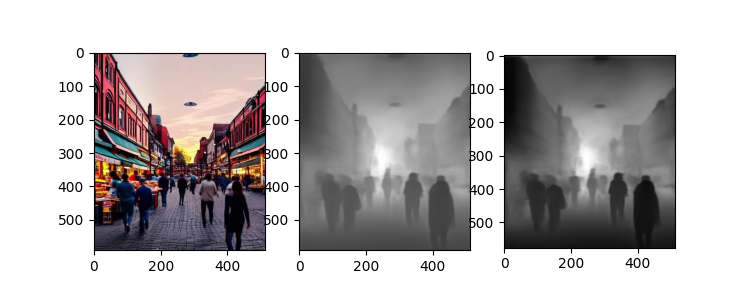

In [26]:
from PIL import Image
street = Image.open("images/image.webp")
display_depths(street, depth_estimator)

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
"""
Helper Function to display the images in a folder, their depth maps, and their predicted depths with both models.
Displays the image inside of the function in a display_count x 4 grid and does not return any values.

Parameters
----------
img_folder_path: the path (relative or absolute) to the image folder
    Note: do not include a final slash at the end

display_count: the number of images to be displayed
    If this argument is not given, this function will display all the images in the folder.

img_names: an optional list of strings with the file names of specific images to display
"""
def display_img_depths(img_folder_path="images", display_count=None, img_names=None):
    # Load both models
    depth_model = pipeline(task="depth-estimation", model="vinvino02/glpn-nyu")
    depth_model2 = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

    grid_out = 0    # The image output after running the depth estimator
    orig_img = None # The original PIL Image  
    num_cols = 4    # The number of columns: original, depth, predicted_depth, depth2
    image_paths = os.listdir(img_folder_path)

    # If the image files are specified, use those as the paths
    if (img_names is not None):
        image_paths = img_names

    # Display all the images in the folder if the count is not specified
    if (display_count == None):
        display_count = len(image_paths)

    plt.figure(figsize=(2.5 * num_cols, 3 * display_count))
    for ind, f in enumerate(image_paths):
        # Stop when the display_count is reached
        if (ind == display_count):
            break
        
        # Display the original image
        plt.subplot(display_count, num_cols, ind * num_cols + 1)
        orig_img = Image.open(f"{img_folder_path}/{f}")
        plt.imshow(orig_img)

        # Display the depth map
        plt.subplot(display_count, num_cols, ind * num_cols + 2)
        grid_out = depth_model(orig_img)
        plt.imshow(grid_out["depth"], cmap='gray', vmin=0, vmax=255)

        # Display the predicted depth original image
        plt.subplot(display_count, num_cols, ind * num_cols + 3)
        plt.imshow(grid_out["predicted_depth"][0], cmap='gray')

        # Display the depth map with the second model
        plt.subplot(display_count, num_cols, ind * num_cols + 4)
        grid_out2 = depth_model2(orig_img)
        plt.imshow(grid_out2["depth"], cmap='gray', vmin=0, vmax=255)



display_img_depths(img_names=["abraham.jpg", "book.webp", "lib1.webp", "liberty.jpg", "mason_statue.webp", "mess.JPG", "room.jpg"])

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [12]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="vinvino02/glpn-nyu")
depth_estimator2 = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

vinv_out = depth_estimator("images/mason_statue.webp")
lihe_out = depth_estimator2("images/mason_statue.webp")

print("vinvino02/glpn-nyu predicted depths: ")
print(vinv_out["predicted_depth"][0])
print()
print("LiheYoung/depth-anything-base-hf predicted depths: ")
print(lihe_out["predicted_depth"][0])

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


vinvino02/glpn-nyu predicted depths: 
tensor([[4.6720, 4.5679, 4.6044,  ..., 4.0672, 4.1436, 4.4319],
        [4.3762, 4.1609, 4.0639,  ..., 3.0523, 3.1774, 3.5820],
        [4.7215, 4.8062, 4.7904,  ..., 3.4987, 3.6191, 3.6452],
        ...,
        [2.0153, 2.0338, 2.0272,  ..., 1.7286, 1.7187, 1.7247],
        [2.0743, 2.0051, 2.0559,  ..., 1.7351, 1.8466, 1.7523],
        [2.1529, 2.1191, 2.0184,  ..., 1.7027, 1.7451, 1.8103]])

LiheYoung/depth-anything-base-hf predicted depths: 
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0933,  0.1155,  0.1690],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0513,  0.1113,  0.2426],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0488,  0.0868,  0.3080],
        ...,
        [48.1569, 48.1648, 48.1972,  ..., 46.9048, 47.0102, 46.7920],
        [48.3864, 48.2530, 48.3937,  ..., 47.1890, 47.1778, 47.0735],
        [43.4572, 48.3352, 48.6044,  ..., 47.3126, 47.4236, 43.8536]])


### 2.2.1 Starting the Creation of Point Clouds: Literal Depth for Each Pixel

In [13]:
# Create a new array that will be used to visualize the depth map. 
# The x coordinate will be 0 to depth.shape[1] and the y coordinate will the depth value, and the z coordinate will be 0 to depth.shape[0]
output = depth_estimator("images/room.jpg")
x = np.asarray(output["predicted_depth"][0])
max = np.max(x)

map = []
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        map.append([j, max-x[i, j], x.shape[0]-i])
        
map = np.array(map)

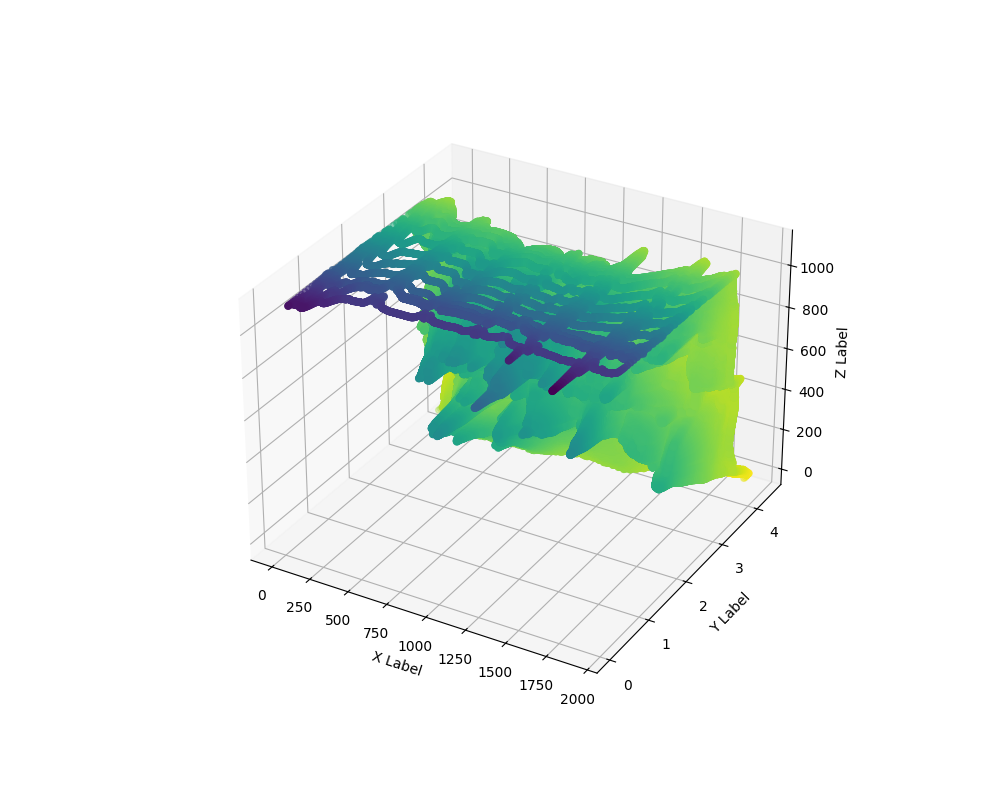

In [14]:
# Plot the depth map in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# compress the depth map to simplify the visualization
#map = map[::10]


# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map[:, 0], map[:, 1], map[:, 2], c=map[:, 1], cmap='viridis', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### 2.2.2 Point Clouds: Calculating (X,Y,Z) for Each Image Pixel

In [15]:
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

"""
Creates the 3D point cloud for a specific image using a depth estimation model.
Cuts off the points with a depth larger than the threshold.
NOTE: the default intrinsic parameters were used for testing to display the area visibly (Would flatten the scene otherwise)

Parameters
----------
img: a string with the path to the image or a Pillow Image object of the image

depth_checkpoint: the depth_estimator string to load the model

f_x: the camera's focal length along the x-axis

f_y: the camera's focal length along the y-axis

c_x: the x-coordinate of the optical center

c_y: the y-coordinate of the optical center

threshold: the maximum distance shown in the point cloud

"""
def fx_point_cloud(img, depth_checkpoint="vinvino02/glpn-nyu", f_x=400, f_y=400, c_x=0, c_y=0, threshold=4):
    # Load the depth estimator model
    depth_estimator = pipeline(task="depth-estimation", model=depth_checkpoint)

    # Estimate depth from an image
    output = depth_estimator(img)
    depth_map = output["predicted_depth"][0]

    # Convert depth_map to a numpy array
    depth_map = np.array(depth_map, dtype=np.float32)

    # Find the minimum non-zero depth value (closest object)
    min_depth = np.min(depth_map[np.nonzero(depth_map)])

    # Prepare to generate point cloud
    height, width = depth_map.shape
    point_cloud = []

    # Create the points for every 5th point (uses a step value to decrease storage / time)
    for i in range(0, height, 5):
        for j in range(0, width, 5):
            Z = depth_map[i, j]
            
            # Check if the depth value is within a certain range around the minimum depth
            if Z > 0 and abs(Z - min_depth) < threshold:            
                X = (j - c_x) * Z / f_x
                Y = (i - c_y) * Z / f_y
                point_cloud.append([X, Z, -Y])   # Can change back to X, Y, Z for the coordinates
                
    
    point_cloud = np.array(point_cloud)
    # Save the point cloud
    np.savetxt('point_cloud.xyz', point_cloud)

    # Reshape the array to have two dimensions
    point_cloud = point_cloud.reshape(-1, 3)

    # Extracting individual components
    x = point_cloud[:, 0]
    y = point_cloud[:, 1]
    z = point_cloud[:, 2]

    # Function to update the plot
    def update_plot(colormap='viridis', point_size=5, azimuth=0, elevation=30):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(x, y, z, c=y, cmap=colormap, marker='o', s=point_size)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.view_init(elev=elevation, azim=azimuth)
        plt.show()

    update_plot()
    return output

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


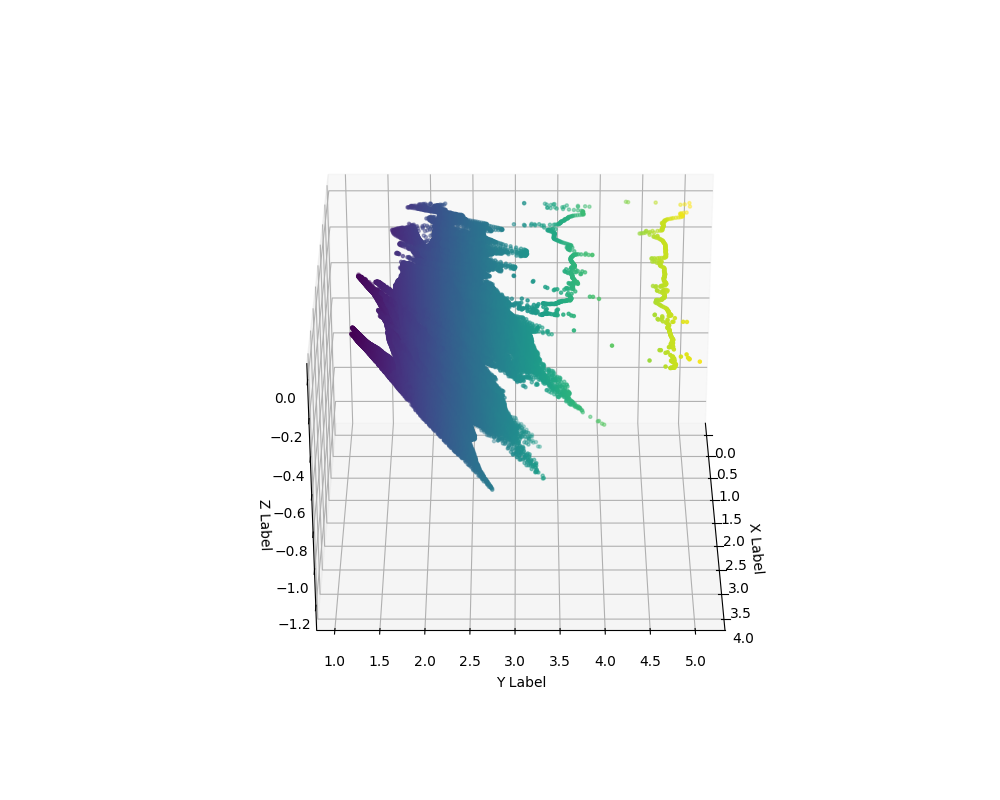

{'predicted_depth': tensor([[[4.2965, 4.1487, 4.2520,  ..., 3.5955, 3.6634, 4.1033],
          [3.4370, 3.1291, 3.0671,  ..., 1.7580, 1.8124, 2.3803],
          [3.4524, 3.4978, 3.5382,  ..., 2.2368, 2.2888, 2.3992],
          ...,
          [1.5214, 1.5508, 1.5425,  ..., 1.0929, 1.0880, 1.0500],
          [1.5645, 1.5009, 1.5646,  ..., 1.1010, 1.1846, 1.0418],
          [1.6624, 1.6189, 1.5135,  ..., 1.0827, 1.1131, 1.1484]]]),
 'depth': <PIL.Image.Image image mode=L size=1920x1111>}

In [22]:
from PIL import Image
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

"""
Helper Function to display an image and its depth maps or point clouds across multiple transformations.

Parameters
----------
img: a Pillow Image object of the image

depth_model: the depth_estimator model being used (specifically the checkpoint string).

transforms: a list of convolution kernels relating to an image transform

titles: the text that will be displayed above the middle image in each transform

cloud_bool: a boolean value that determines if images or the point clouds are displayed

"""
def display_transforms(img, depth_model="vinvino02/glpn-nyu", transforms=[], titles=[], cloud_bool=False):
    # Assert there is a title for every transform
    assert len(transforms) == len(titles)

    # Create the depth estimator model
    depth_estimator = pipeline(task="depth-estimation", model=depth_model)
    img_array = np.asarray(img)[:, :, 0]
    num_imgs = 1 + len(transforms)
    
    # Create the original point cloud or the depth maps for the image
    if (cloud_bool is True):
        fx_point_cloud(img)
    
    else:
        plt.figure(figsize=(7.5, 3*num_imgs))
        plt.subplot(num_imgs, 3, 1)
        plt.imshow(img)
        depths = depth_estimator(img)
        plt.subplot(num_imgs, 3, 2)
        plt.imshow(depths["depth"], cmap='gray', vmin=0, vmax=255)
        plt.title("Original Image")

        plt.subplot(num_imgs, 3, 3)
        plt.imshow(depths["predicted_depth"][0], cmap='gray')

    # For every image: apply the transformation and display the point cloud or the depths maps
    for ind, (transform, title) in enumerate(zip(transforms, titles)):
        transformed = Image.fromarray(scipy.signal.convolve2d(img_array, transform, mode='same'))
        
        if (cloud_bool is True):
            fx_point_cloud(transformed)

        else:
            depth_transformed = depth_estimator(transformed)
            plt.subplot(num_imgs, 3, 3 * ind + 4)        
            plt.imshow(transformed)

            plt.subplot(num_imgs, 3, 3 * ind + 5)
            plt.imshow(depth_transformed["depth"], cmap='gray', vmin=0, vmax=255)
            plt.title(title)

            plt.subplot(num_imgs, 3, 3 * ind + 6)
            plt.imshow(depth_transformed["predicted_depth"][0], cmap='gray')

    

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


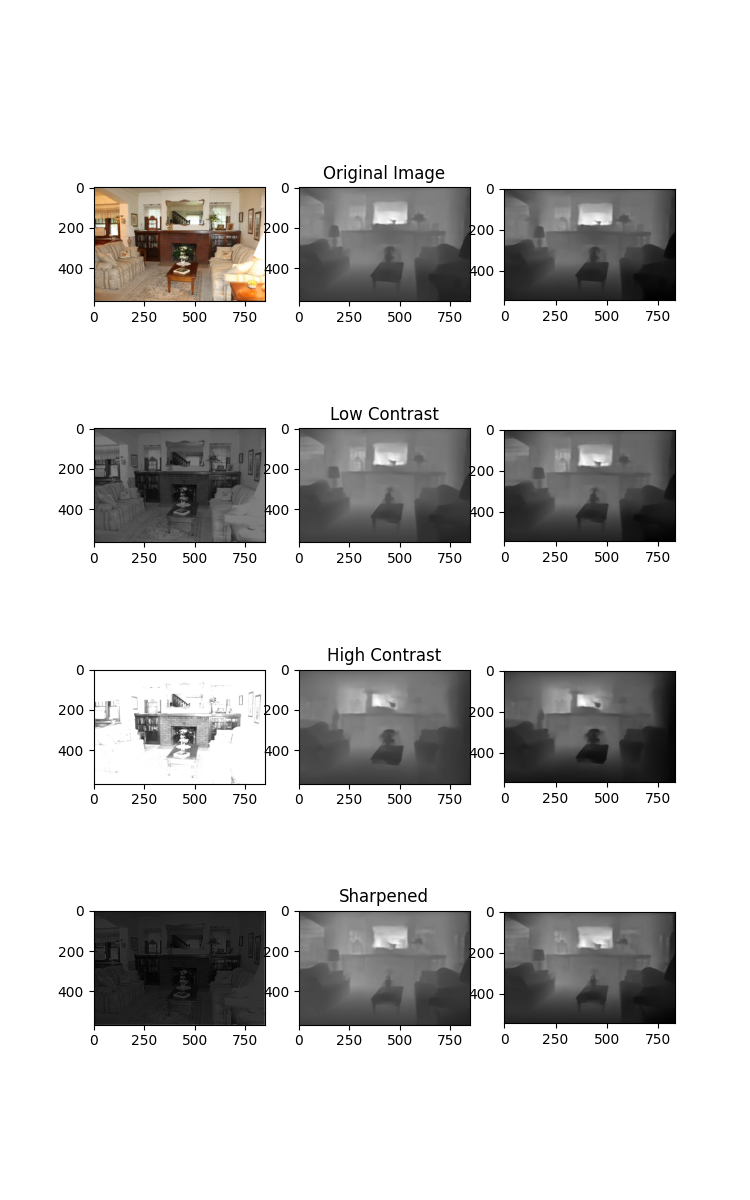

In [23]:
# Display the transformations for one of the room images for comparison
img = Image.open("images/room2.webp")
low_contrast = np.zeros((3, 3))
low_contrast[1, 1] = 0.5

high_contrast = np.zeros((3, 3))
high_contrast[1, 1] = 2

sharpen = np.zeros((3, 3))
sharpen[1, 1] = 2
sharpen = sharpen - (1.0 / 5) * np.ones((3, 3))

transforms = [low_contrast, high_contrast, sharpen]
display_transforms(img, transforms=transforms, titles=["Low Contrast", "High Contrast", "Sharpened"])

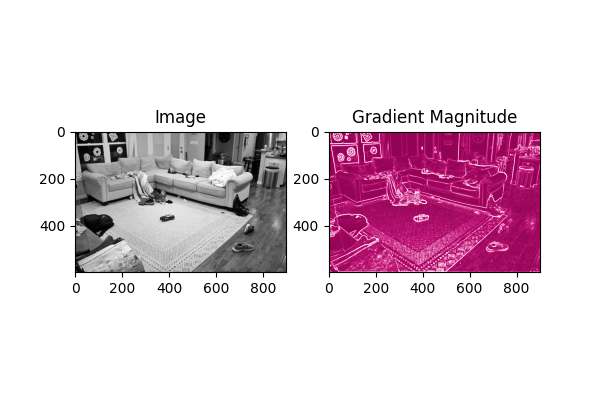

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.signal

"""
Displays an image and the gradient magnitude over the image.

Parameters
----------
image: a 2-dimensional Numpy array with the pixel values


Return Value: a 2-dimensional Numpy array storing the gradient magnitudes
"""
def plot_gradient_magn(image):
    # Get the Sobel Filters for the derivatives
    horizontal_filter = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    vertical_filter = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

    # Display the original image
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1) 
    plt.imshow(image, cmap='gray')
    plt.title("Image")

    # Get the gradient and its magnitude over the image
    x_deriv = scipy.signal.convolve(image, horizontal_filter, mode='same')
    y_deriv = scipy.signal.convolve(image, vertical_filter, mode='same')
    grad_magn = np.sqrt(np.square(x_deriv) + np.square(y_deriv))

    plt.subplot(1, 2, 2)
    plt.imshow(grad_magn, cmap='PiYG')
    plt.title("Gradient Magnitude")
    return grad_magn


image = np.asarray(Image.open("images/mess.JPG"))[:, :, 0]
mess_grad = plot_gradient_magn(image)

### 2.2.3 Additional Improvements to Point Cloud Computation
Goal: To compute homographies reliably to match the point clouds of two corresponding images 

Source of Code: [OpenCV tutorial](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html)

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
img1 = cv.imread("images/roomM.webp", cv.IMREAD_GRAYSCALE)           # queryImage
img2 = cv.imread("images/roomM2.webp", cv.IMREAD_GRAYSCALE)          # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [ ]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

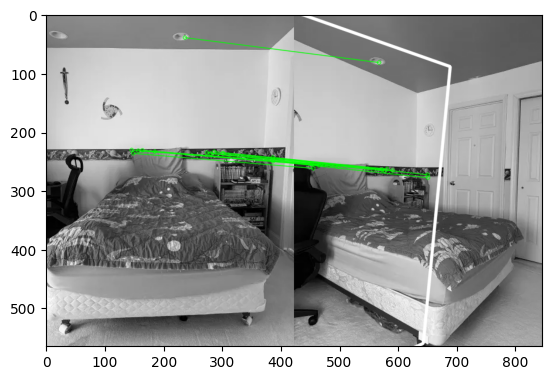

(<matplotlib.image.AxesImage at 0x2650000fbc0>, None)

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

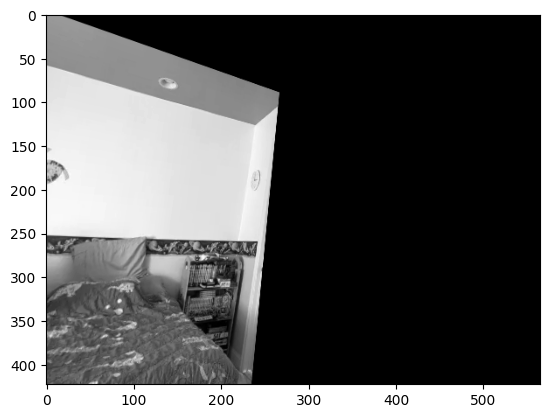

In [ ]:
# Testing the Calculated Homography
warped_img = cv.warpPerspective(img1, M, img1.shape)
plt.figure()
plt.imshow(warped_img, cmap='gray')

### 2.2.4 Path-Planning (In Separate File)